In [1]:
# saves you having to use print as all exposed variables are printed in the cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# matpolitlib config
%matplotlib inline
sns.reset_defaults()
plt.rcParams['figure.figsize'] = 12,4
sns.set_style('whitegrid')

# suppress warning message
import warnings
warnings.filterwarnings('ignore')

%reload_ext autoreload
%autoreload 2

import ds_discovery
import ds_behavioral
print('DTU: {}'.format(ds_discovery.__version__))
print('DBU: {}'.format(ds_behavioral.__version__))

DTU: 1.07.020
DBU: 1.00.030


# Titanic Dataset



In [2]:
from ds_behavioral import DataBuilder as DataBuilder
from ds_behavioral import DataBuilderTools as Tools
from ds_discovery.transition.cleaners import ColumnCleaners as Cleaner
from ds_discovery.transition.discovery import DataDiscovery as Discover
from ds_discovery.transition.features import FeatureBuilders as Feature
from ds_behavioral.sample.sample_data import ProfileSample

In [3]:
titanic = sns.load_dataset('titanic')

In [4]:


Discover.analysis_dictionary(titanic)

,Attribute,Type,Unique,% Nulls,Sample,Selection,Weighting,Granularity,Lower,Upper
0,adult_male,bool,2,0.00,891,"[True, False]","[60.27, 39.73]",2,,
1,age,float64,88,19.87,714,"[(0.42, 26.947), (26.947, 53.473), (53.473, 80.0)]","[35.8, 38.72, 5.61]",3,0.42,80
2,alive,object,2,0.00,891,,,,,
3,alone,bool,2,0.00,891,"[False, True]","[39.73, 60.27]",2,,
4,class,category,3,0.00,891,"[Third, First, Second]","[55.11, 24.24, 20.65]",3,,
5,deck,category,7,77.22,203,"[C, E, G, D, A, B, F]","[29.06, 15.76, 1.97, 16.26, 7.39, 23.15, 6.4]",7,,
6,embark_town,object,3,0.00,891,,,,,
7,embarked,object,3,0.00,891,,,,,
8,fare,float64,248,0.00,891,"[(0.0, 170.776), (170.776, 341.553), (341.553, 512.329)]","[97.76, 1.91, 0.34]",3,0,512.329
9,parch,int64,7,0.00,891,"[(0, 2), (2, 4), (4, 6)]","[89.34, 9.54, 1.12]",3,0,6


In [5]:
Discover.data_dictionary(titanic)

,Attribute,Type,% Nulls,Count,Unique,Observations
0,adult_male,bool,0.00,891,2,True | False
1,age,float64,0.20,714,88,max=80.0 | min=0.42 | mean=29.7
2,alive,object,0.00,891,2,Sample: yes | no
3,alone,bool,0.00,891,2,False | True
4,class,category,0.00,891,3,First|Second|Third
5,deck,category,0.77,203,7,A|B|C|D|E|F|G
6,embark_town,object,0.00,889,3,Sample: Southampton | Queenstown | Cherbourg
7,embarked,object,0.00,889,3,Sample: C | S | Q
8,fare,float64,0.00,891,248,max=512.3292 | min=0.0 | mean=32.2
9,parch,int64,0.00,891,7,max=6 | min=0 | mean=0.38


### Replace NaN's from Age
We could clean NaN's in age with 

`Cleaner.to_int_type(titanic, headers=['age'], fillna='mode', inplace=True)`

Which would fill the age NaN's with the mode of the age (see Cleaner.to_int_type(...) for more info)

But ultimately it will just fill NaN values with a single value. Not ideal

Alternatively: We can use our analysis tool to get an age weighting and then replace NaN with values that represent that weighting, giving us a much more representative distribution

In [6]:
# save the origional stats to compare later
age_stats = Discover.stat_dictionary(titanic)['age']

# firstly get the analysis dictionary with an age frequency of 5 years, keep the lower boundary as 1
analysis = Discover.analyse_number(titanic['age'], granularity=5.0, lower=1)
lower = analysis.get('lower')
upper = analysis.get('upper')
weight_pattern = analysis.get('weighting')

# now replace the nan's with a representative distribution
size = len(titanic['age'][titanic['age'].isna()])
titanic['age'][titanic['age'].isna()] = Tools.get_number(from_value=lower, to_value=upper, weight_pattern=weight_pattern, precision=0, size=size)

In [7]:
# comparing the before and after stats
stats = Discover.stat_dictionary(titanic)
stats['pre_nan_age'] = age_stats

Cleaner.filter_columns(stats, regex='age')

,pre_nan_age,age
dtype,float64,float64
count,714,891
unique,88,88
mean,29.7,30.17
median,28,28
var,210.72,204.11
std,14.52,14.29
min,0.42,0.42
25%,20.12,21
50%,28,28


### Titanic Visualisation
A quick look over the origional titanic dataset

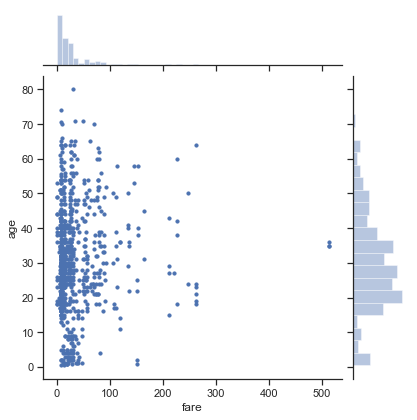

In [8]:
# Age against Fare
sns.set(style="ticks", color_codes=True)
g = sns.jointplot(x='fare',y='age',data=titanic, s=10)

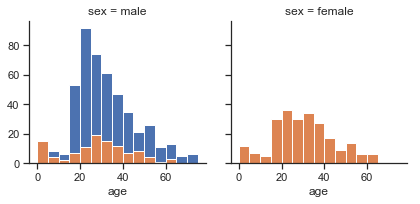

In [9]:
# Age Gender distribution of survived as a hue
sns.set(style="ticks", color_codes=True)
bins = np.arange(0, 80, 5)
g = sns.FacetGrid(data=titanic, col='sex', hue='survived')
g.map(plt.hist, 'age', bins=bins)

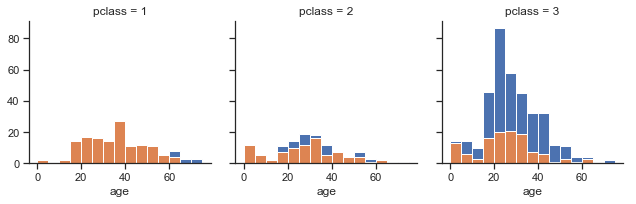

In [10]:
# Age against class with the hue of survived
sns.set(style="ticks", color_codes=True)
bins = np.arange(0, 80, 5)
g = sns.FacetGrid(data=titanic, col='pclass', hue='survived')
g.map(plt.hist, 'age', bins=bins)

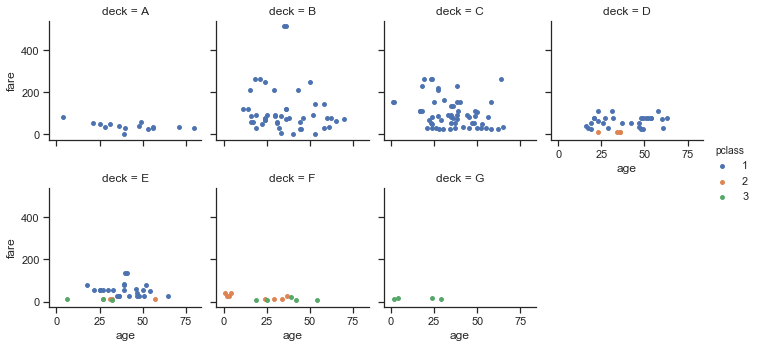

In [11]:
# Age against fair across the decks with a hueof class
sns.set(style="ticks", color_codes=True)
g = sns.FacetGrid(data=titanic, col='deck', hue='pclass', col_wrap=4, height=2.5)
g = g.map(plt.scatter, 'age', 'fare', s=15).add_legend()
g.fig.subplots_adjust(wspace=0.1, hspace=0.4)

# Synthetic Titanic dataset
Time to now build the synthetic data and see how it compares

In [12]:
builder = DataBuilder('titanic')
tools = builder.tools

## Clean the dataset

In [13]:
df = Cleaner.auto_to_category(titanic)
bool_map = {'yes': True, '1': True, 'True': True}
df = Cleaner.to_bool_type(df, bool_map=bool_map, headers=['adult_male', 'alive', 'alone', 'survived'])
Discover.data_dictionary(df)

,Attribute,Type,% Nulls,Count,Unique,Observations
0,adult_male,bool,0.00,891,2,True | False
1,age,float64,0.00,891,88,max=80.0 | min=0.42 | mean=30.17
2,alive,bool,0.00,891,2,False | True
3,alone,bool,0.00,891,2,False | True
4,class,category,0.00,891,3,First|Second|Third
5,deck,category,0.77,203,7,A|B|C|D|E|F|G
6,embark_town,category,0.00,891,4,Cherbourg|Queenstown|Southampton|nan
7,embarked,category,0.00,891,4,C|Q|S|nan
8,fare,float64,0.00,891,248,max=512.3292 | min=0.0 | mean=32.2
9,parch,category,0.00,891,7,0|1|2|3|4|5|6


## Characteristics of the dataset
By using the analysis tools we can extract out the relational charactersitcs of the dataset

#### Create the columns association reference
This reference dictionary outlines how we percived the columns in the dataset and their levels of associating
- level 1
    - sex
- level 2
    - age
- level 3
    - pclass
    - sibsp - **end**
- level 4
    - alone - **end**
    - survived - **end**
    - fare 
- level 5 
    - embarked - **end**

In [14]:
column_association = [{'sex': {}}, 
                      {'age': {'granularity': 16, 'precision': 0}}, 
                      {'pclass': {'dtype': 'category'}, 'sibsp': {'dtype': 'category'}},
                      {'survived': {'dtype': 'category'}, 'fare': {'granularity': 20, 'precision': 2}, 'alone': {'dtype': 'category'}},
                      {'embarked': {}}]

exclude_associate = ['sex.age.sibsp.fare', 'sex.age.sibsp.survived', 'sex.age.sibsp.alone', 'sex.age.pclass.survived.embarked', 'sex.age.pclass.alone.embarked']

analysis = Discover.analyse_association(titanic, columns_list=column_association, exclude_associate=exclude_associate)


In [15]:
df_syn = tools.associate_analysis(analysis, size=1000)


Add in the 'embark_town' by correlating the 'embarked' categories

In [16]:
actions = {0: {'action': 'Cherbourg'}, 1: {'action': 'Southampton'}, 2: {'action': 'Queenstown'}}
df_syn['embark_town'] = tools.correlate_categories(df_syn['embarked'], correlations=['C', 'S', 'Q'], actions=actions, value_type='category')


The last field of interest is the decks. We can analyse the decks from the class. we can then build an association

In [17]:
column_association = [{'pclass': {'dtype': 'category'}}, {'deck': {}}]
analysis = Discover.analyse_association(titanic, columns_list=column_association)
selection_1 = analysis.get('pclass').get('sub_category').get(1).get('deck').get('analysis').get('selection')
weighting_1 = analysis.get('pclass').get('sub_category').get(1).get('deck').get('analysis').get('weighting')
selection_2 = analysis.get('pclass').get('sub_category').get(2).get('deck').get('analysis').get('selection')
weighting_2 = analysis.get('pclass').get('sub_category').get(2).get('deck').get('analysis').get('weighting')
selection_3 = analysis.get('pclass').get('sub_category').get(3).get('deck').get('analysis').get('selection')
weighting_3 = analysis.get('pclass').get('sub_category').get(3).get('deck').get('analysis').get('weighting')


In [18]:
associations = [{'pclass': {'expect': 'category', 'value': [1]}},
                {'pclass': {'expect': 'category', 'value': [2]}},
                {'pclass': {'expect': 'category', 'value': [3]}}]

actions = {0: {'action': 'get_category', 'kwargs' : {'selection': selection_1, 'weight_pattern': weighting_1}},
           1: {'action': 'get_category','kwargs' : {'selection': selection_2, 'weight_pattern': weighting_2}},
           2: {'action': 'get_category','kwargs' : {'selection': selection_3, 'weight_pattern': weighting_3}}}

df_syn['deck'] = tools.associate_dataset(df_syn, associations=associations, actions=actions, default_value='')

In [19]:
builder.save_to_disk(df_syn, filename='darryl_titanic_2.csv')

In [20]:
Discover.data_dictionary(df_syn)

,Attribute,Type,% Nulls,Count,Unique,Observations
0,age,float64,0.00,1000,989,max=78.184 | min=0.302 | mean=29.31
1,alone,bool,0.00,1000,2,False | True
2,deck,object,0.00,1000,7,Sample: F | E | A
3,embark_town,object,0.08,925,3,Sample: Southampton | Cherbourg | Queenstown
4,embarked,object,0.08,925,3,Sample: S | C | Q
5,fare,float64,0.00,1000,959,max=493.07 | min=0.025 | mean=32.16
6,pclass,int64,0.00,1000,3,max=3 | min=1 | mean=2.32
7,sex,object,0.00,1000,2,Sample: male | female
8,sibsp,int64,0.00,1000,7,max=8 | min=0 | mean=0.53
9,survived,int64,0.00,1000,2,max=1 | min=0 | mean=0.35


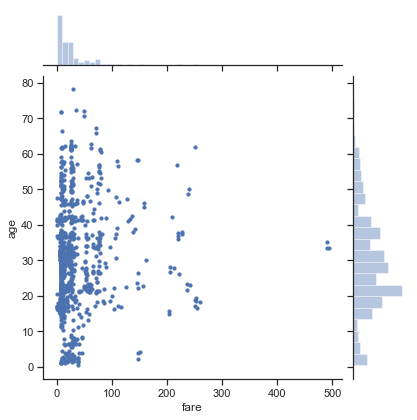

In [21]:
sns.set(style="ticks", color_codes=True)
g = sns.jointplot(x='fare',y='age',data=df_syn, s=10)

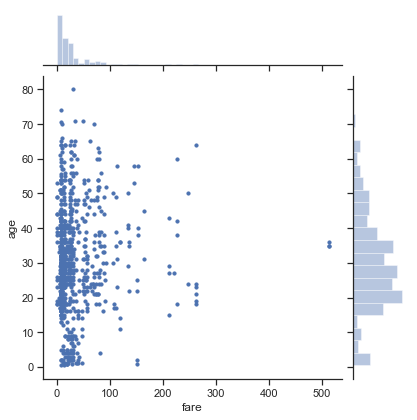

In [22]:
sns.set(style="ticks", color_codes=True)
g = sns.jointplot(x='fare',y='age',data=titanic, s=10)

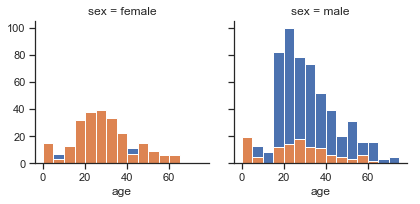

In [23]:
sns.set(style="ticks", color_codes=True)
bins = np.arange(0, 80, 5)
g = sns.FacetGrid(data=df_syn, col='sex', hue='survived')
g.map(plt.hist, 'age', bins=bins)

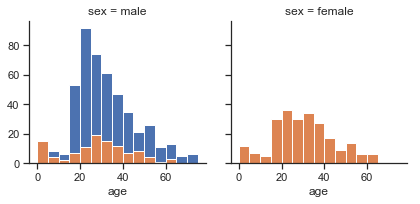

In [24]:
sns.set(style="ticks", color_codes=True)
bins = np.arange(0, 80, 5)
g = sns.FacetGrid(data=titanic, col='sex', hue='survived')
g.map(plt.hist, 'age', bins=bins)

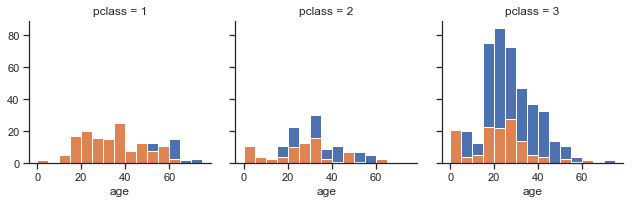

In [25]:
sns.set(style="ticks", color_codes=True)
bins = np.arange(0, 80, 5)
g = sns.FacetGrid(data=df_syn, col='pclass', hue='survived')
g.map(plt.hist, 'age', bins=bins)

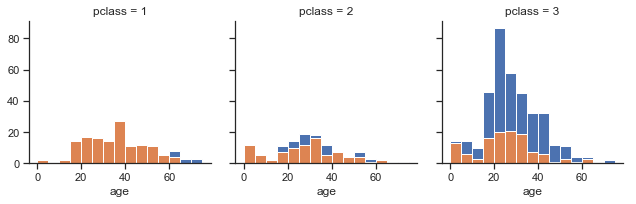

In [26]:
sns.set(style="ticks", color_codes=True)
bins = np.arange(0, 80, 5)
g = sns.FacetGrid(data=titanic, col='pclass', hue='survived')
g.map(plt.hist, 'age', bins=bins)

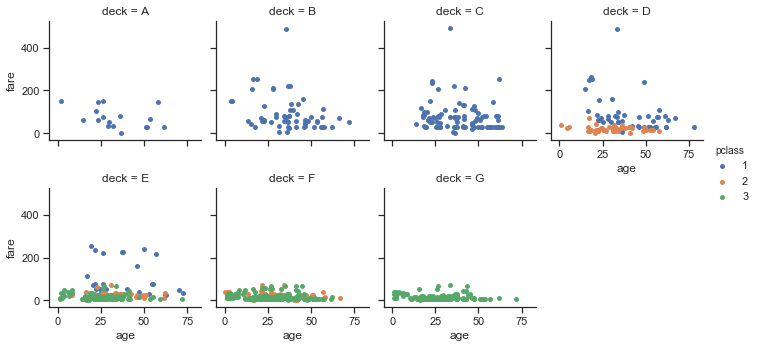

In [27]:
df_syn = df_syn.sort_values(by=['deck'])
sns.set(style="ticks", color_codes=True)
g = sns.FacetGrid(data=df_syn, col='deck', hue='pclass', col_wrap=4, height=2.5)
g = g.map(plt.scatter, 'age', 'fare', s=15).add_legend()
g.fig.subplots_adjust(wspace=0.1, hspace=0.4)

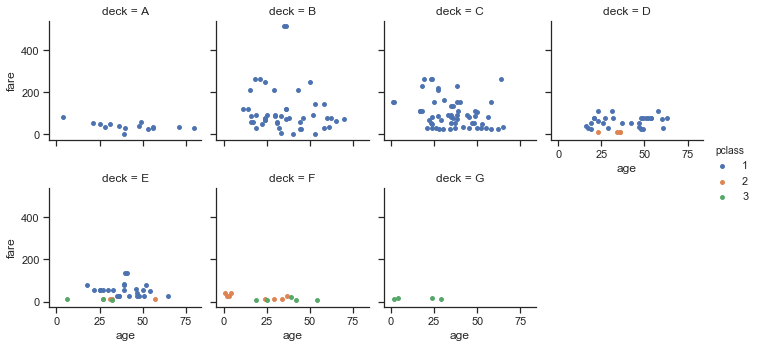

In [28]:
sns.set(style="ticks", color_codes=True)
g = sns.FacetGrid(data=titanic, col='deck', hue='pclass', col_wrap=4, height=2.5)
g = g.map(plt.scatter, 'age', 'fare', s=15).add_legend()
g.fig.subplots_adjust(wspace=0.1, hspace=0.4)